# Build Training Data

Here we output our training, testing and validation datasets to be
used in all downstream notebooks.

In [1]:
import pandas as pd
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

In [2]:
notes = pd.read_table('../data/raw/notes-00000.tsv')
ratings = pd.read_table('../data/raw/ratings-00000.tsv')
tweets = pd.read_csv('../data/raw/tweet_text2021-11-04.csv')

## Splitting Data

In [3]:
english_tweet_ids = tweets.loc[tweets['lang'] == 'en', 'id']
filtered_notes = notes[notes['tweetId'].isin(english_tweet_ids)].reset_index(drop=True)
print('Filtering', len(tweets) - len(english_tweet_ids), 'out of', len(tweets),
      'tweets written in languages other than English')

Filtering 761 out of 12874 tweets written in languages other than English


In [4]:
note_size = len(filtered_notes)
# drop notes without a summary
filtered_notes = filtered_notes[~filtered_notes['summary'].isna()].reset_index(drop=True)
print('Filtered', note_size - len(filtered_notes), 'notes without a summary')

Filtered 2 notes without a summary


In [5]:
note_size = len(filtered_notes)
# drop notes without any ratings
filtered_notes = (filtered_notes[filtered_notes['noteId'].isin(ratings['noteId'])]
                  .reset_index(drop=True))
print('Filtered', note_size - len(filtered_notes), 'notes without a rating')

Filtered 4782 notes without a rating


In [6]:
groups = filtered_notes['tweetId']
group_kfold = GroupKFold(n_splits=10) #1/10 -> 10% for val and testing
group_kfold.get_n_splits(X=filtered_notes, groups=groups)
train_notes_list = []
for i, (_, test_index) in enumerate(group_kfold.split(X=filtered_notes, groups=groups)):
    if i == 0:
        test_notes = filtered_notes.iloc[test_index, :]
    elif i == 1:
        val_notes = filtered_notes.iloc[test_index, :]
    else:
        train_notes_list.append(filtered_notes.iloc[test_index, :])
train_notes = pd.concat(train_notes_list)

In [7]:
print('Training set notes:', train_notes.shape[0])
print('Validation set notes:', val_notes.shape[0])
print('Testing set notes:', test_notes.shape[0])

Training set notes: 8861
Validation set notes: 1108
Testing set notes: 1108


### Generating outputs

For the ratings data in order to combine the old and new API's, we
assign any rating with a 'helfulnessLevel' of "NOT_HELPFUL" a output
value of 0, and 1 otherwise.

In [8]:
def get_helful_out(row):
    if pd.isna(row['helpfulnessLevel']):
        return row['helpful']
    else:
        if row['helpfulnessLevel'] == 'NOT_HELPFUL':
            return 0
        else:
            return 1

ratings['output'] = (ratings
                     .apply(get_helful_out, axis=1))

With this scheme, we see about 2/3 of the dataset consists of helpful ratings,
whereas 1/3 consists of unhelpful ratings

In [9]:
ratings['output'].value_counts()

1    79311
0    42128
Name: output, dtype: int64

Given the long tail in ratings, where some notes have upwards of 100 ratings,
and others only have one, we'll use a scaling factor for model
training and evaluation.

This scaling factor for each rating is simply $\frac{1}{\text{# ratings}}$
for each note.

(array([1.1643e+04, 7.9300e+02, 2.4300e+02, 1.0000e+02, 5.5000e+01,
        2.2000e+01, 2.2000e+01, 1.0000e+01, 5.0000e+00, 2.0000e+00]),
 array([  1. ,  22.4,  43.8,  65.2,  86.6, 108. , 129.4, 150.8, 172.2,
        193.6, 215. ]),
 <BarContainer object of 10 artists>)

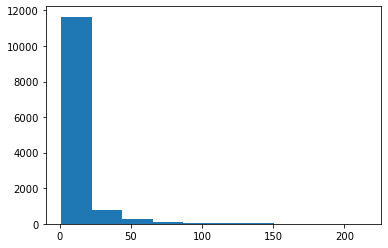

In [10]:
plt.hist(ratings['noteId'].value_counts())

In [11]:
ratings['scaling'] = (ratings.groupby(['noteId'])
                      ['participantId']
                      .transform(lambda x: 1/x.nunique()))

We'll merge the notes dataframe with the ratings dataframe.

In [12]:
merged_dfs = (notes.merge(tweets[['id', 'text', 'author_id',
                                  'public_metrics.retweet_count',
                                  'public_metrics.reply_count',
                                  'public_metrics.like_count',
                                  'public_metrics.quote_count']]
                          .rename({'id': 'tweetId', 'text': 'tweet_text',
                                   'author_id': 'tweet_author_id'}, axis=1),
                          how='inner', on='tweetId')
              .merge(ratings[['noteId', 'output', 'scaling']],
                     how='inner', on=['noteId']))

While the merged dataframe has 30 columns, there are three columns that will
be core to training and testing:

* summary: note summary
* output: binary rating of whether a note was helpful
* sacling: scaling factor for training and testing

In [13]:
print('Note columns:', ', '.join(merged_dfs.columns[:22]))
print('Tweet columns:', ', '.join(merged_dfs.columns[22:28]))
print('Rating columns:', ', '.join(merged_dfs.columns[28:]))


Note columns: noteId, participantId, createdAtMillis, tweetId, classification, believable, harmful, validationDifficulty, misleadingOther, misleadingFactualError, misleadingManipulatedMedia, misleadingOutdatedInformation, misleadingMissingImportantContext, misleadingUnverifiedClaimAsFact, misleadingSatire, notMisleadingOther, notMisleadingFactuallyCorrect, notMisleadingOutdatedButNotWhenWritten, notMisleadingClearlySatire, notMisleadingPersonalOpinion, trustworthySources, summary
Tweet columns: tweet_text, tweet_author_id, public_metrics.retweet_count, public_metrics.reply_count, public_metrics.like_count, public_metrics.quote_count
Rating columns: output, scaling


### Split merged dataset into training, testing, and validation sets


In [14]:
train_merged = (merged_dfs[merged_dfs['noteId'].isin(train_notes['noteId'])]
                .reset_index(drop=True))
val_merged = (merged_dfs[merged_dfs['noteId'].isin(val_notes['noteId'])]
              .reset_index(drop=True))
test_merged = (merged_dfs[merged_dfs['noteId'].isin(test_notes['noteId'])]
              .reset_index(drop=True))



In [15]:
print('Train ratings:', str(len(train_merged)))
print('Val ratings:', str(len(val_merged)))
print('Test ratings:', str(len(test_merged)))

Train ratings: 88185
Val ratings: 11641
Test ratings: 10507


In [16]:
train_merged.to_csv('../data/processed/training_data.csv', index=False)
val_merged.to_csv('../data/processed/val_data.csv', index=False)
test_merged.to_csv('../data/processed/test_data.csv', index=False)